# Data Driven Astronomy


Flux density in radio astronomy is measured in units of Janskys
$$ 1Jy = 10^{-26} \frac{W}{m^2\quad Hz} $$

One of the most widely used formats for astronomical images is the Flexible Image Transport System. In a FITS file, the image is stored in a numerical array, which we can load into a NumPy array.

FITS files also have headers which store metadata about the image.

FITS files are a standard format and astronomers have developed many libraries (in many programming languages) that can read and write FITS files. We're going to use the Astropy module.

In [1]:
# import packages
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# directory with the input files
folder = './astronomy_files/'

In [3]:
hdulist = fits.open(folder+'image0.fits')
hdulist.info()

Filename: ./astronomy_files/image0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (200, 200)   float64   


Opening a FITS file in Astropy returns a HDU (Header/Data Unit) list. Each HDU stores headers and (optionally) image data.

The header contains metadata about the HDU object, e.g. its dimensions and data type. Every HDU can contain image data. The first HDU is called the primary HDU.

If we want to access individual HDUs, we can index the HDU list object returned by fits.open. 

In [4]:
data = hdulist[0].data
print(data.shape)

(200, 200)


The image data is conveniently stored in a NumPy array, so we can operate on it directly.

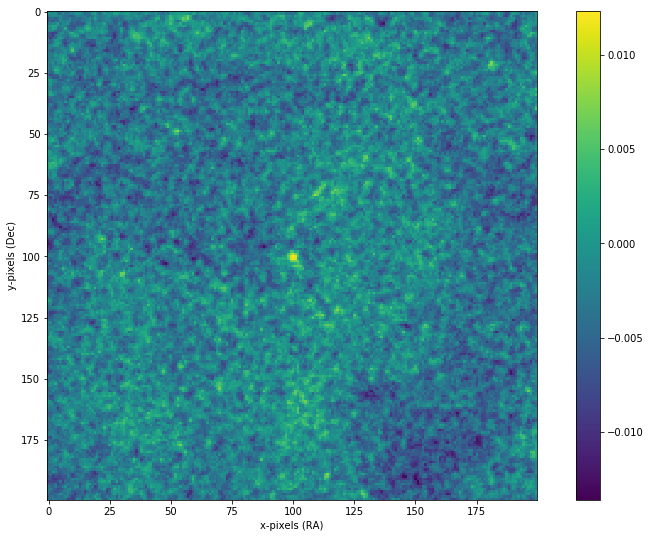

In [5]:
# Plot the 2D array
plt.figure(figsize=(14,9))
plt.imshow(data, cmap=plt.cm.viridis)
plt.xlabel('x-pixels (RA)')
plt.ylabel('y-pixels (Dec)')
plt.colorbar()

Write a load_fits function that loads in a FITS file and finds the position of the brightest pixel (i.e. the maximum value) in its image data. To make this function work for arbitrary files, pass the name of the FITS file as an argument to the function.

In [6]:
def load_fits(file):
    hdulist = fits.open(file)
    data = hdulist[0].data
    i,j = np.unravel_index(data.argmax(), data.shape)
    
    return (i, j)

In [7]:
load_fits(folder+'image0.fits')

(100, 100)

Write a mean_fits function that takes a list of FITS files as an argument, reads them in, and returns the mean image data of the FITS files. All the images have the same dimensions and your calculated mean array should match those dimensions.

In [8]:
# Write your mean_fits function here:
def mean_fits(lst):
    hdulist = fits.open(lst[0])
    data = hdulist[0].data
    
    for k in range(1,len(lst)):
        hdulist = fits.open(lst[k])
        data += hdulist[0].data
    
    return data/len(lst)

In [9]:
data  = mean_fits([folder+'image0.fits', folder+'image1.fits', folder+'image2.fits'])
print(data[100, 100])

0.017356586332122486


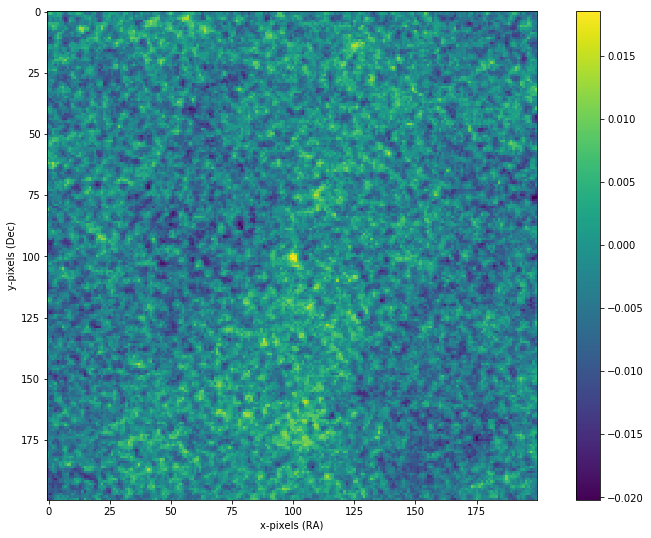

In [10]:
# Plot the 2D array
plt.figure(figsize=(14,9))
plt.imshow(data, cmap=plt.cm.viridis)
plt.xlabel('x-pixels (RA)')
plt.ylabel('y-pixels (Dec)')
plt.colorbar()

The [binapprox algorithm](http://www.stat.cmu.edu/~ryantibs/papers/median.pdf) saves time and space by only looking for the median within one standard deviation of the mean.

The full algorithm for a set of  data points works as follows:

1. Calculate their mean and standard deviation, $\mu$ and $\sigma$

2. Set the bounds: minval = $\mu-\sigma$ and maxval = $\mu+\sigma$. Any value >= maxval is ignored;

3. Set the bin width: width = $2\sigma/B$;

4. Make an ignore bin for counting value < minval;

5. Make  bins for counting values in minval and maxval, e.g. the first bin is minval <= value < minval + width;

6. Count the number of values that fall into each bin;

7. Sum these counts until total$>= (N + 1)/2$. Remember to start from the ignore bin;

8. Return the midpoint of the bin that exceeded $(N + 1)/2$.

The midpoint of a bin is just the average of its min and max boundaries, i.e. the lower boundary + width/2.

As soon as the relevant bin is updated the data point being binned can be removed from memory. So if you're finding the median of a bunch of FITS files you only need to have one loaded at any time. (The mean and standard deviation can both be calculated from running sums so that still applies to the first step).

The downside of using binapprox is that you only get an answer accurate to $\sigma/B$ by using $B$ bins. Scientific data comes with its own uncertainties though, so as long as you keep $B$ large enough this isn't necessarily a problem.

In [11]:
# Write your median_bins and median_approx functions here.
def median_bins(values, B):
    # Calculate their mean and standard deviation
    vals_mean = np.mean(values)
    vals_std  = np.std(values)
    
    # Set the bounds
    minval = vals_mean - vals_std
    
    # Set the bin width
    width = 2*vals_std/B
    
    # Make an ignore bin for counting value < minval
    a = np.array(values)
    less_min = len(np.where(a<minval)[0])
    
    # Make bins for counting values in minval and maxval,
    # e.g. the first bin is minval <= value < minval + width;
    # Count the number of values that fall into each bin;
    bins = np.zeros(B)
    
    for k in range(B):
        bins[k] = len(np.where(np.logical_and(a>=minval+k*width, a<=minval+(k+1)*width))[0])
        
    return (vals_mean, vals_std, less_min, bins)
  

def median_approx(values, B):
    sig, mu, less, bins = median_bins(values, B)
    
    width = 2*mu/B
    
    for k in range(B):
        # Sum these counts until total>=(N+1)/2. Remember to start from the ignore bin;
        less += bins[k]
        if (less >= (len(values)+1)/2):
            break
            
    # Return the midpoint of the bin that exceeded (N+1)/2
    return (sig-mu)+(k+0.5)*width

In [12]:
def running_stats(filenames):
    '''Calculates the running mean and stdev for a list of FITS files using Welford's method.'''
    n = 0
    
    for filename in filenames:
        hdulist = fits.open(filename)
        data = hdulist[0].data
        if n == 0:
            mean = np.zeros_like(data)
            s = np.zeros_like(data)
    
    n += 1
    delta = data - mean
    mean += delta/n
    s += delta*(data - mean)
    hdulist.close()
    
    s /= n - 1
    np.sqrt(s, s)
    
    if n < 2:
        return mean, None
    else:
        return mean, s

# Write your median_bins_fits and median_approx_fits here:
def median_bins_fits(lst,B):
    res = running_stats(lst)
    
    # Set the bounds
    minval = res[0] - res[1]
    
    # Set the bin width
    width = 2.*res[1]/B
    
    data = []
    left_bin = np.zeros((200,200))
    bins = np.zeros((200,200,B))
    
    for k in range(len(lst)):
        hdulist = fits.open(lst[k])
        data.append(hdulist[0].data)
        
    for n in range(200):
        for m in range(200):
            vls = []
            
            for k in range(len(lst)):
                vls.append(data[k][n,m])
            
            a = np.array(vls)
            left_bin[n,m] = len(np.where(a<minval[n,m])[0])
            
            for k in range(B):
                bins[n,m,k] = len(np.where(np.logical_and(a>=minval[n,m]+k*width[n,m],
                                                          a<minval[n,m]+(k+1)*width[n,m]))[0])
                
    return res[0], res[1], left_bin, bins
      
def median_approx_fits(lst, B):
    sig, mu, left_bin, bins = median_bins_fits(lst,B)
    
    width = 2.*mu/B
    
    result = np.zeros((200,200))
    
    for n in range(200):
        for m in range(200):
            for k in range(B):
                left_bin[n,m] +=  bins[n,m,k]
                if (left_bin[n,m] >= (len(lst)+1)/2):
                    result[n,m] = k
                    break
    
    return (sig-mu)+(result+0.5)*width

## A naive cross-matcher

When investigating astronomical objects, like active galactic nuclei (AGN), astronomers compare data about those objects from different telescopes at different wavelengths.

This requires positional cross-matching to find the closest counterpart within a given radius on the sky.

In this activity you'll cross-match two catalogues: one from a radio survey, [the AT20G Bright Source Sample (BSS) catalogue](http://cdsarc.u-strasbg.fr/viz-bin/Cat?J/MNRAS/384/775) and one from an optical survey, [the SuperCOSMOS all-sky galaxy catalogue](http://ssa.roe.ac.uk/allSky).

The BSS catalogue lists the brightest sources from the AT20G radio survey while the SuperCOSMOS catalogue lists galaxies observed by visible light surveys. If we can find an optical match for our radio source, we are one step closer to working out what kind of object it is, e.g. a galaxy in the local Universe or a distant quasar.

We've chosen one small catalogue (BSS has only 320 objects) and one large one (SuperCOSMOS has about 240 million) to demonstrate the issues you can encounter when implementing cross-matching algorithms.

_The positions of stars, galaxies and other astronomical objects are usually recorded in either equatorial or Galactic coordinates._

_Equatorial coordinates are fixed relative to the celestial sphere, so the positions are independent of when or where the observations took place. They are defined relative to the celestial equator (which is in the same plane as the Earth's equator) and the ecliptic (the path the sun traces throughout the year)._

_A point on the celestial sphere is given by two coordinates:_

__Right ascension__: _the angle from the vernal equinox to the point, going east along the celestial equator; given in hours-minutes-seconds (HMS) notation, because it was convenient to calculate when a star would appear over the horizon. A full circle in HMS notation is 24 hours, which means 1 hour in HMS notation is equal to 15 degrees._

__Declination__: _the angle from the celestial equator to the point, going north (negative values indicate going south), is traditionally recorded in degrees-minutes-seconds (DMS) notation. A full circle is 360 degrees, each degree has 60 arcminutes and each arcminute has 60 arcseconds._

_The vernal equinox is the intersection of the celestial equator and the ecliptic where the ecliptic rises above the celestial equator going further east._

In [13]:
""" Write two functions, one that converts right ascension from HMS 
    to decimal degrees, called hms2dec, and another that converts 
    declination from DMS to decimal degrees, called dms2dec.
    Right ascension is always an angle from 0 to 24 hours and 
    declination is always an angle from -90° to +90°."""

# Write your hms2dec and dms2dec functions here
def hms2dec(hour,mns, secs):
    return 15*(hour + mns/60 + secs/(60*60))

def dms2dec(gds, mns, secs):
    a = 1
    if gds < 0:
        a = -1
    
    return a*(abs(gds) + mns/60 + secs/(60*60))

To crossmatch two catalogues we need to compare the angular distance between objects on the celestial sphere.

People loosely call this a "distance", but technically its an angular distance: the projected angle between objects as seen from Earth.

If we have an object on the celestial sphere with right ascension and declination $(\alpha_1, \delta_1)$, then the angular distance to another object with coordinates is:

$$ d = 2 \arcsin \sqrt{ \sin^2 \frac{|\delta_1 - \delta_2|}{2} + \cos \delta_1 \cos \delta_2 \sin^2 \frac{|\alpha_1 - \alpha_2|}{2} } $$

The haversine formula, is good at avoiding floating point errors when the two points are close together.

In [14]:
def angular_dist(ra1, de1, ra2, de2):
    r1 = np.radians(ra1)
    d1 = np.radians(de1)
    r2 = np.radians(ra2)
    d2 = np.radians(de2)
    
    b = np.cos(d1)*np.cos(d2)*np.sin(np.abs(r1 - r2)/2)**2
    a = (np.sin(0.5*abs(d1-d2)))**2
    
    d = 2*np.arcsin(np.sqrt(a + b))
    
    return np.degrees(d)

Before we can crossmatch our two catalogues we first have to import the raw data. Every astronomy catalogue tends to have its own unique format so we'll need to look at how to do this with each one individually.

We'll look at the AT20G bright source sample survey first. The raw data we'll be using is the file table2.dat from [this page](http://cdsarc.u-strasbg.fr/viz-bin/Cat?J/MNRAS/384/775) in the VizieR archives, but we'll use the filename __bss.dat__ from now on.

Every catalogue in VizieR has a detailed README file that gives you the exact format of each table in the catalogue.

The catalogue is organised in fixed-width columns, with the format of the columns being:

* 1: Object catalogue ID number (sometimes with an asterisk)
* 2-4: Right ascension in HMS notation
* 5-7: Declination in DMS notation
* 8-: Other information, including spectral intensities

We only need coordinates for crossmatching. We can load specific columns with the usecols argument in NumPy's loadtxt function:

In [15]:
cat = np.loadtxt(folder+'bss.dat', usecols=range(1, 7))
print(cat[0])

[  0.     4.    35.65 -47.    36.    19.1 ]


In [16]:
# Write your import_bss function here.
def import_bss(file):
    cat = np.loadtxt(file, usecols=range(1, 7))
    res = []
    
    for k in range(cat.shape[0]):
        res.append((k+1,hms2dec(cat[k,0],cat[k,1],cat[k,2]),dms2dec(cat[k,3],cat[k,4],cat[k,5])))
    
    return res

The SuperCOSMOS all-sky catalogue is a catalogue of galaxies generated from several visible light surveys.

The original data is available on [this page](http://ssa.roe.ac.uk/allSky) in a package called SCOS_XSC_mCl1_B21.5_R20_noStepWedges.csv.gz. Because this catalogue is so large, we've cut it down for these activities. The cut down version of the file will be named super.csv.

The catalogue uses a comma-separated value (CSV) format. Aside from the first row, which contains column labels, the format is:

* 1: Right ascension in decimal degrees
* 2: Declination in decimal degrees
* 3: Other data, including magnitude and apparent shape

So now when loading this file in, we have to tell np.loadtxt to skip the first row and treat the commas as delimiters.

In [17]:
cat = np.loadtxt(folder+'super.csv', delimiter=',', skiprows=1, usecols=[0, 1])
print(cat)

[[  1.0583407 -52.9162402]
 [  2.6084425 -41.5005753]
 [  2.7302499 -27.706955 ]]


In [18]:
def import_super(file):
    cat = np.loadtxt(file, delimiter=',', skiprows=1, usecols=[0, 1])
    
    res = []
    
    for k in range(cat.shape[0]):
        res.append((k+1,cat[k,0],cat[k,1]))
        
    return res

Write a find_closest function that takes a catalogue and the position of a target source (a right ascension and declination) and finds the closest match for the target source in the catalogue.

Your function should return the ID of the closest object and the distance to that object.

In [19]:
# Write your find_closest function here
def find_closest(lst, ra1, de1):
    N = len(lst)
    res = np.zeros(N)
    
    for k in range(N):
        res[k] = angular_dist(ra1, de1, lst[k][1], lst[k][2])
        
    return (np.argmin(res)+1,min(res))

In [20]:
cat = import_bss(folder+'bss_long.dat')

# First example from the question
print(find_closest(cat, 175.3, -32.5))

# Second example in the question
print(find_closest(cat, 32.2, 40.7))

(156, 3.7670580226469053)
(26, 57.729135775621295)


You now have all the tools necessary to crossmatch the BSS and SuperCOSMOS catalogues. In the next problem you'll put it all together to see how many of the bright radio sources in the BSS catalogue have a counterpart in the SuperCOSMOS catalogue. The process you should follow is:

Select an object from the BSS catalogue;

1. Go through all the objects in SuperCOSMOS and find the closest one to the BSS object;
2. If the objects are close enough, record the match;
3. Repeat 1-3 for all the other objects in the BSS catalogue.
4. In step 3, if the closest object isn't within a given distance then it's unlikely that the two objects are actually counterparts, and it's more likely that they just happen to be nearby.

The given distance you choose depends on the uncertainty of the measured object positions in each catalogue.

Write a crossmatch function that crossmatches two catalogues within a maximum distance. It should return a list of matches and non-matches for the first catalogue against the second.

The list of matches contains tuples of the first and second catalogue object IDs and their distance. The list of non-matches contains the unmatched object IDs from the first catalogue only. Both lists should be ordered by the first catalogue's IDs.

The BSS and SuperCOSMOS catalogues will be given as input arguments, each in the format you’ve seen previously. The maximum distance is given in decimal degrees.

In [21]:
# Write your crossmatch function here.
def crossmatch(bssC, superC, maxD):
    match = []
    noMatch = []
    
    for point in bssC:
        res = find_closest(superC, point[1], point[2])
        
    if res[1] <= maxD:
        match.append((point[0], res[0], res[1]))
    else:
        noMatch.append(point[0])
        
    return match, noMatch

In [22]:
bss_cat = import_bss(folder+'bss_long.dat')
super_cat = import_super(folder+'super_long.csv')

# First example in the question
max_dist = 40/3600
matches, no_matches = crossmatch(bss_cat, super_cat, max_dist)
print(matches[:3])
print(no_matches[:3])
print(len(no_matches))

[]
[160]
1


In [23]:
# Second example in the question
max_dist = 5/3600
matches, no_matches = crossmatch(bss_cat, super_cat, max_dist)
print(matches[:3])
print(no_matches[:3])
print(len(no_matches))

[]
[160]
1


Crossmatching is a very common task in astrophysics, so it's natural that it's had optimised implementations written of it already. A popular implementation in Python is found in the [Astropy](http://www.astropy.org/) module and it uses objects called [k-d trees](https://en.wikipedia.org/wiki/K-d_tree) to perform crossmatching incredibly quickly.

Astropy constructs a k-d tree out of the second catalogue, letting it search through for a match for each object in the first catalogue efficiently. Constructing a k-d tree is similar to the binary search you saw earlier. The k-dimensional space is divided into two parts recursively until each division only contains only a single object. Creating a k-d tree from an astronomy catalogue works like this:

1. Find the object with the median right ascension, split the catalogue into objects left and right partitions of this
2. Find the objects with the median declination in each partition, split the partitions into smaller partitions of objects down and up of these
3. Find the objects with median right ascension in each of the partitions, split the partitions into smaller partitions of objects left and right of these
4. Repeat 2-3 until each partition only has one object in it

This creates a binary tree where each object used to split a partition (a node) links to the two objects that then split the partitions it has created (its children).

Once you've made a k-d tree out of a catalogue, finding a match to an object then works like this:

1. Calculate the distance from the object to highest level node (the root node), then go to the child node closest (in right ascension) to the object
2. Calculate the distance from the object to this child, then go to the child node closest (in declination) to the object
3. Calculate the distance from the object to this child, then go to the child node closest (in right ascension) to the object
4. Repeat 2-3 until you reach a child node with no further children (a leaf node)
5. Find the shortest distance of all distances calculated, this corresponds to the closest object

Since each node branches into two children, a catalogue of $N$ objects will have, on average, $\log_2(N)$ nodes from the root to any leaf. So while it seems like a lot of effort to create a k-d tree, doing so lets you, for example, search the entire SuperCOSMOS catalogue of 250 million objects using only 28 distance calculations.

In [24]:
from astropy.coordinates import SkyCoord
from astropy import units as u

coords1 = [[270, -30], [185, 15]]
coords2 = [[185, 20], [280, -30]]

sky_cat1 = SkyCoord(coords1*u.degree, frame='icrs')
sky_cat2 = SkyCoord(coords2*u.degree, frame='icrs')

closest_ids, closest_dists, closest_dists3d = sky_cat1.match_to_catalog_sky(sky_cat2)

print(closest_ids)
print(closest_dists)

[1 0]
[8d39m27.0001s 5d00m00s]


## Querying databases using SQL (Structured Query Language)

* The most widely used database query language. SQL is designed especially for data management in relational databases.
* Every query takes one or more tables as arguments and returns a new table with the requested data.
* Every SQL statement ends with a semicolon.

__FROM__: which table to query
__WHERE__: which rows from that table to pick
__SELECT__: identifies the columns of this rows to be included in the new table

Example: select all the planets from the exoplanet database that ave a radius smaller than 0.6

```sql
SELECT *
FROM Exoplanet
WHERE RADIUS < 0.6
```

Information about stars and their exoplanets, are sampled from the [NASA exoplanet archive](http://exoplanetarchive.ipac.caltech.edu/).

1. Specifying the attributes (or columns): rather than retrieving all (*) attributes from a table, we can select specific columns right after the SELECT keyword (KOI names and the radii of the planets):

```sql
SELECT koi_name, radius FROM Planet;
```

2. 2. Formulating conditions: SQL queries are typically conditional – you only request data which meets certain conditions. In simple cases, we can make a conditional query using the WHERE clause with comparisons like:

```sql
SELECT koi_name, radius FROM Planet 
WHERE radius < 2;
```

* In general, SQL includes a standard set of Boolean operators, e.g. __AND__ or __NOT__.
* The numerical comparison operators also work on strings, which are declared using single quotation marks.

Note that while SQL syntax is case insensitive, strings are not. If you're unsure what capitalisation is used in an attribute, you can use the UPPER or LOWER function to convert the attribute and then perform the comparison.

```sql
SELECT UPPER('aBc') = 'ABC';
SELECT LOWER('aBc') = 'abc';
```

Both are True.


We can also combine conditions in a WHERE clause using for example the logical __AND__. This allows us to, for example, perform range queries over a set of data. Suppose we want to find all the stars in our Star table whose radius lies between one and two earth radii.

```sql
SELECT radius FROM Star
WHERE radius >= 1 AND radius <= 2;
```

Since range queries are quite common, SQL provides its own syntax for these queries using the BETWEEN statement. With this, we can rewrite the query from above in a more readable form as:

```sql
SELECT radius FROM  Star
WHERE radius BETWEEN 1 AND 2;
```

__BETWEEN__ comparisons are inclusive on both end points, so the two queries above are equivalent.

To query a table, we need to know what columns it contains. If we haven't got any information about the table, we can use the __\d__ statement to get a description of the table's columns.

__\d__ returns a description each column: its name, data type and optional modifiers. The type character varying(20) indicates that this column can hold up to 20 characters. 

Some columns have a __not null__ modifier. This means that when adding data to this table, these attributes must be specified. Other attributes can be left blank. The concept of a NULL value in SQL is quite important.

In our Planet table, not all exoplanets have a Kepler name because they aren't all confirmed planets. In SQL, missing values are represented by __NULL__ values, which are equivalent to an empty field.

A __NULL is not__ equivalent to an empty string.

This is a peculiarity of SQL databases – comparison operators cannot return true or false here since the __NULL__ value is unknown. If we want to find out whether an attribute is actually a NULL value, we have to use the __IS__ comparison.

```sql
SELECT ('' = NULL) IS NULL; 
```

Suppose we want to write a query to find the _kepler_name_ and _radius_ of each planet in a Planet table which is a confirmed exoplanet, meaning that their _kepler_name_ is not NULL, or, equivalently, whose _status_ is 'CONFIRMED'.

Restrict your results to those planets whose radius lies between one and three earth radii, and remember that the radius of the planets is relative to the earth radius.

```sql
SELECT kepler_name, radius FROM Planet
WHERE kepler_name IS NOT NULL AND radius BETWEEN 1. AND 3.;
```

```sql
SELECT kepler_name, radius FROM Planet
WHERE status = 'CONFIRMED' AND radius BETWEEN 1. AND 3.;
```

***
et's analyse the size of the unconfirmed exoplanets.

Your task is to write a query that calculates the:

minimum radius;
maximum radius;
average radius; and
standard deviation of the radii
of unconfirmed planets (with a NULL value in kepler_name) in the Planet table.
As databases increase in size, printing out a full table of all the requested data might not be instructive anymore or even feasible. In these cases, we can in principle make the query more specific to limit the results, but if we don't know a priori what results to expect, we need a better way of characterising the size and statistics of the data and to limit the overall results.

As opposed to returning the requested data in table format, we can use the COUNT function to only return the number of rows in the table we requested. To count, for example, all planets in the Planet table, we can use it like this:

```sql
SELECT COUNT(*) FROM Planet;
```

We can combine counting with all of the other SQL statements that we have seen before. It effectively replaces the attributes that you request right after the SELECT statement. Counting only the confirmed planets would for example work like this:

```sql
SELECT COUNT(*) FROM Planet
WHERE kepler_name IS NOT NULL;
```

The COUNT function that we've seen on the last slide belongs to SQL's aggregate functions. An aggregate function returns a single value which was calculated based on one or more columns.

SQL offers a range of aggregate functions which are very valuable for extracting some statistical information from databases. Knowing what data, or what range of data to expect can help to make a query more specific. 

* COUNT - Number of rows returned
* MIN - Minimum value of a column
* MAX - Maximum value of a column
* SUM - Sum over the column
* AVG - Mean (average) value of a column
* STDDEV - Standard deviation of a column


```sql
SELECT MIN(radius), MAX(radius), AVG(radius)
FROM Planet;
```

We could also calculate an average ourselves using the division operator / in the SELECT clause and compare it to the built-in AVG:


```sql
SELECT SUM(t_eff)/COUNT(*), AVG(t_eff)
FROM Star;
```

The rows in a table may not not be sorted in a useful order. In our tables, they appear in the order in which the stars and planets were added to the database.

We can use an ORDER BY clause to change the sort order. To sort the planets by their radius in descending order. 

The DESC stands for descending order; for ascending order we use ASC or put nothing.

In addition to sorting, we can restrict the number of rows returned using the LIMIT clause. If we are only interested in the five largest planets we could write:


```sql
SELECT koi_name, radius FROM Planet 
ORDER BY radius DESC
LIMIT 5;
```

Let's analyse the size of the unconfirmed exoplanets. The task is to write a query that calculates the:

* minimum radius;
* maximum radius;
* average radius; and
* standard deviation of the radii
* of unconfirmed planets (with a NULL value in kepler_name) in the Planet table.


```sql
SELECT MIN(radius), MAX(radius), AVG(radius), STDDEV(radius) FROM Planet
WHERE kepler_name IS NULL;
```

***

What if we want to work with subsets of the table simultaneously?

But first of all, what do we mean by working with different subsets simultaneously? Imagine the following problem: we want to find out if there are multiple planets within the Planet table that have the same size, as measured by their radius. How can we do that? We can write a simple query in which we order the results such that we can see multiple occurences of the same radius.

But this is not really useful to look at. Much better would be, if we could count the radii which occur multiple times in the table.

For situations like this, we can use the GROUP BY clause, which arranges identical data in groups on which we can perform aggregate functions, like COUNT. To solve our problem from above, we can query the table like this:

```sql
SELECT radius, COUNT(koi_name) 
FROM Planet 
GROUP BY radius;
```

This query returns a table which is grouped by the planet radii, and contains the radii and the number of koi_names belonging to each radius. 

This solution still produces a somewhat lenghty table, but it's a lot better than our first approach. Let's have a look at how we can refine this.

If we want to restrict the results from the last slide to only those where the count is larger than one, we can add a condition for this value. Previously, we've added conditions using the WHERE clause, but if we try the following:

```sql
SELECT radius, COUNT(koi_name) 
FROM Planet 
WHERE COUNT(koi_name) > 1
GROUP BY radius;
```

__ The query fails because WHERE gets processed before the GROUP BY clause and does therefore not have access to aggregate functions. __

In order to use aggregate functions in our conditions, we require the HAVING statement instead of WHERE, which gets called after the GROUP BY clause:

```sql
SELECT radius, COUNT(koi_name) 
FROM Planet 
GROUP BY radius
HAVING COUNT(koi_name) > 1;
```

Other attributes can still be used in WHERE conditions, just as we saw before:

```sql
SELECT radius, COUNT(koi_name) 
FROM Planet 
WHERE t_eq BETWEEN 500 AND 1000
GROUP BY radius
HAVING COUNT(koi_name) > 1;
```


You need to find out how many planets in the Planet database are in a multi-planet system. Planets sharing the same star will have the same kepler_id, but different koi_name values.

Your query should return a table in which each row contains the kepler_id of the star and the number of planets orbiting that star (i.e. that share this kepler_id).

Limit your results to counts above one and order the rows in descending order based on the number of planets.

```sql
SELECT kepler_id, COUNT(koi_name) 
FROM Planet 
GROUP BY kepler_id
HAVING COUNT(koi_name) > 1
ORDER BY COUNT(koi_name) DESC;
```

### Joining tables in SQL

```sql
SELECT *
FROM Exoplanet JOIN Star USING (kepler_id)
WHERE status = 'CONFIRMED'
```


Until now we have worked with one table at a time. However, there are many scenarios in which the information in a single table is not sufficient to answer our questions.

We have put stars and planets in separate tables. Apart from being conceptually different, they have different physical properties.

Separate tables also eliminates redundancy. If the star data was copied for each planet, every update to a star's measurements may require multiple rows in the Planet table to be updated.

But, if we want to study the entire planetary system surrounding a star, we need both tables.

We can use SQL's join operations to combine two or more tables in our queries to get all the information we want.

There are several ways to join data from multiple tables in SQL, the simplest one is called an equi-join. An equi-join usually tests for equality on attributes shared across tables.

For example, our Star and Planet tables share the kepler_id attribute, which links planets to their respective stars.

Using this column, we can join the data in both tables in two steps:

1. List both tables in the __FROM__ clause
2. Require the common attribute to match in a __WHERE__ condition

```sql
SELECT Star.kepler_id, Planet.koi_name
FROM Star, Planet
WHERE Star.kepler_id = Planet.kepler_id;
```

The query above returns the kepler_id and the planet's unique koi_name. For each kepler_id, there may be more than one koi_name, meaning that the planets share the same star.

***

***

## Setting up your own database

As a starting point, let's have a look at how we can modify data in an existing table.

There are three basic commands to manipulate a table's content:

* **INSERT**: inserts a new row into a table;
* **DELETE**: deletes a specified row;
* **UPDATE**: changes attributes within a row.

We're going to look at each of them in turn using a small version of our Star table from the previous activity.

The **INSERT** statement adds a row to an existing table using the following syntax:

```sql
INSERT INTO <tablename> (<attributes>) VALUES (...);
```

You can optionally pass a list of attributes that define the order. The data goes into the **VALUES** (...) clause. For example, let's add a new star to our Star table:

```sql
INSERT INTO Star (kepler_id, t_eff, radius)  
VALUES (2713050, 5000, 0.956);
```

Have a look at the table before and after the **INSERT** command using **SELECT** * **FROM** Star.

You can insert multiple rows at once using multiple tuples of values:
 
```sql
INSERT INTO Star (kepler_id, t_eff, radius) VALUES
  (2713050, 5000, 0.956),
  (2713051, 3100, 1.321);
```

It is not always necessary to include a list of the attributes, it is still good practice. If the order of the columns in the table change, you don't have to change the **INSERT** command if you've set the order of attributes in there. For example, the following command works just as well as the one above:

```sql
INSERT INTO Star (kepler_id, radius, t_eff)
VALUES (2713050, 0.956, 5000);
```

The **DELETE** statement deletes zero or more rows in the selected table. The rows are selected using a **WHERE** clause:

```sql
DELETE FROM <tablename> WHERE <condition>;
```

If we want to delete a planet in the Planet table with a kepler_id of 2713049, we would put this condition in the **WHERE** clause:

```sql
SELECT * FROM Planet
WHERE kepler_id = 2713049;
 
DELETE FROM Planet
WHERE kepler_id = 2713049;
 
SELECT * FROM Planet
WHERE kepler_id = 2713049;
```

If you don't include a condition in the **DELETE** statement which only affects a selection of rows, all rows will be deleted:

```sql
DELETE FROM Planet;
SELECT * FROM Planet;
```

The **UPDATE** statement allows us to modify one or more attributes of existing rows using the following syntax:

```sql
UPDATE <tablename>
SET <expression>
WHERE <condition>
```

The attributes that we want to change are specified within the **SET** clause and we'll use a condition to select the row in which we want to make the changes.

For example, let's suppose that we want to change the temperature of the star with kepler_id = 2713049:

```sql
SELECT * FROM Star
WHERE kepler_id = 2713049;
 
UPDATE Star
SET t_eff = 6000
WHERE kepler_id = 2713049;
 
SELECT * FROM Star
WHERE kepler_id = 2713049;
```

Again, make sure that you always include the condition in an **UPDATE** command, otherwise all samples will get that attribute.

After looking at how to modify data in existing tables, let's have a look at how to set up new tables from scratch.

For this, we're going to use the **CREATE TABLE** statement which adds a new table to a database using the following syntax:

```sql
CREATE TABLE <tablename> (
  <attribute1>  <type1>(size1) <constraint1>,
  <attribute2>  <type2>(size2) <constraint2>,
  ...
);
```

Each attribute must have a specified data type with optional size argument. Table attributes may also have additional constraints, which establish further rules that the data in the table has to fulfill.

SQL uses standard data types that may have size arguments, specifying e.g. the length of a string. A few of the most commonly used data types are listed below:

|Data type|	Description|
|:---:|:---:|
|SMALLINT|	Signed two-byte integer|
|INTEGER|	Signed four-byte integer|
|FLOAT|	Eight-byte floating-point number|
|CHAR(n)|	Fixed-length string with n characters|
|VARCHAR(n)|	Variable-length string with maximum n characters|

With these data types, we can now set up a table from scratch. Let's have a look at how our Star table is created:

```sql
CREATE TABLE Star (
  kepler_id INTEGER,
  t_eff INTEGER,
  radius FLOAT
);

INSERT INTO Star VALUES
  (10341777, 6302, 0.815);
```

In addition to the required data type, each attribute may additionally be constrained to only hold data of a specified form. For this, SQL uses so-called consistency constraints which are specified right after the data type in the **CREATE TABLE** command.

Constraints enforce rules for data that is added to the table. We have already encountered the **NOT NULL** constraint when we were looking at a table's structure using the **\d** statement. This constraint forbids the attribute from being empty. Other constraints are:

|Constraint type|	Description|
|---|---|
|NOT NULL|	Value cannot be NULL|
|UNIQUE|	Value must be unique in the table|
|DEFAULT|	Specifies a default if the field is left blank|
|CHECK|	Ensures that the value meets a specific condition|
|PRIMARY KEY|	Combination of NOT NULL and UNIQUE|
|FOREIGN KEY|	Ensures the data matches the specified attribute in another table|


With these modifiers, we can now, for example, set up the Star table like this:
  
```sql
CREATE TABLE Star (
  kepler_id INTEGER PRIMARY KEY,
  t_eff INTEGER CHECK (t_eff > 3000),
  radius FLOAT
);

INSERT INTO Star VALUES
  (10341777, 6302, 0.815);
```

Where the **kepler_id** is now a unique attribute which is always filled with data. The temperature of any star that is added to the table cannot be lower than 3000K.

What happens if we insert data into a table with the wrong type or violating consistency constraints?

In most cases, inserting the wrong data type should result in an error message and an aborted transaction. However, in some cases, values may be cast into the type required by the table attribute, as it happens in the following example:

```sql
CREATE TABLE Star (
  kepler_id INTEGER
);

INSERT INTO Star VALUES (3.141);
SELECT * FROM Star;

INSERT INTO Star VALUES ('a string');
SELECT * FROM Star;
```

Here the float gets truncated to an integer with no error message. When trying to insert a string the transaction fails.

Consistency constraints cannot be violated by inserting or updating data:

```sql
CREATE TABLE Star (
  kepler_id INTEGER CHECK(kepler_id > 10)
);

INSERT INTO Star VALUES (3);
SELECT * FROM Star;
```

This insertion fails because we're trying to insert an ID < 10, when the consistency constraint requires a value > 10.

Primary and foreign keys are very important constraints in relational databases. We're going to have a closer look at how they work and motivate why you'd want to use these constraints for your tables.

As we've previously, a primary key is a unique identifier of a row and cannot take **NULL** values. We can create a primary key by adding the constraint to an attribute in our table like this:

```sql
CREATE TABLE Star (
  kepler_id INTEGER PRIMARY KEY 
);
```

A table can at most have one primary key, which can be one or more attributes. A primary key enforces data integrity as it forbids duplicates and creates a functional relationship between the key and the other attributes.

It also plays an important role when linking multiple tables together.

A foreign key links data shared between two or more tables, thereby enforcing referential integrity. An attribute with a foreign key constraint is linked to an attribute in another table.

**It can only be filled with a value that exists in the other table.**

For example, *kepler_id* is shared by both stars and planets in our tables and links planets to the stars they orbit.

We can use a foreign key constraint for kepler_id in the Planet table to link the planets to their corresponding stars. The syntax for creating a foreign key constraint is:
 
```sql
CREATE TABLE Star (
  kepler_id INTEGER PRIMARY KEY 
);
  
CREATE TABLE Planet (
  kepler_id INTEGER REFERENCES Star (kepler_id)
);
  
INSERT INTO Star VALUES (10341777);
INSERT INTO Planet VALUES (10341777);
```

Earlier, we inserted data into a table using the INSERT statement:

It is inconvenient to insert large datasets like this. Instead, we can read data from CSV files using the COPY statement:

```sql
COPY <tablename> (attr1, attr2, ...) FROM 'filename' CSV;
```

Let's have a look at an example. We have a CSV file with star attributes in the following order, (kepler_id, t_eff, radius):

```csv
stars.csv

10341777,6302,0.815
11296798,6335,3.523
3836450,5160,0.784
4483235,8782,1.965
6590362,5926,0.887
```

To create and fill the table, we use the following commands:
  
```sql
CREATE TABLE Star (
  kepler_id INTEGER PRIMARY KEY,
  t_eff INTEGER,
  radius FLOAT
);

COPY Star (kepler_id, t_eff, radius) 
  FROM 'stars.csv' CSV;

SELECT * FROM Star;
```

The COPY statement copies the contents of the CSV file into the table. The new rows are added after existing rows.

Up to here we have covered the manipulation of a table's data, i.e. its rows, using the **INSERT**, **DELETE** and **UPDATE** statements. We have also looked at how to create new tables and how to define their attributes and properties.

But what can we do if we not only want to change the data, but also the attributes of the table, i.e. its columns, or their properties after we've created it?

For this, we can use the **ALTER TABLE** command, which allows us to add, delete and modify the columns in an existing table.

To add a new column to an existing table, we use the ADD COLUMN clause in the ALTER TABLE statement:

```sql
ALTER TABLE <tablename>
ADD COLUMN <columnname> <datatype> <modifiers>;
```

To delete a column, we use the DROP COLUMN clause:

```sql
ALTER TABLE <tablename>
DROP COLUMN <columnname>;
```

For example, let's add two columns to capture the equatorial coordinates of the solar systems in RA (ra) and declination (decl) angles to our Star table and remove them again:
  
```sql
SELECT * FROM Star LIMIT 1;

ALTER TABLE Star
ADD COLUMN ra FLOAT,
ADD COLUMN decl FLOAT;
 
SELECT * FROM Star LIMIT 1;

ALTER TABLE Star
DROP COLUMN ra, 
DROP COLUMN decl;
 
SELECT * FROM Star LIMIT 1;
```

We can also use the ALTER TABLE statement to modify the data type and constraints of a column:

```sql
ALTER TABLE <tablename>
ALTER COLUMN <columnname> SET DATA TYPE <newtype>;

ALTER TABLE <tablename>
ADD CONSTRAINT <columnname> <newconstraint>;
```

When changing either the data type or constraint you have to be careful that the change does not conflict with the data in the table.

The query below changes the type of t_eff to float and adds a positive constraint for the radius:
 
```sql
\d Star;

ALTER TABLE Star
 ALTER COLUMN t_eff SET DATA TYPE FLOAT;
 
ALTER TABLE Star
  ADD CONSTRAINT radius CHECK(radius > 0);
 
\d Star;
```


## Combining SQL and Python

An advantage of using a popular language is the high probability that programmers before us have found solutions to our problems already. As such, there exists a Python module which allows us to interface with a PostgreSQL database, called [Psycopg2](http://initd.org/psycopg/docs/).

Using this module requires a quite advanced understanding of Python and SQL, so we'll start off with a very simple query and work through it step by step.

Let's suppose we want to implement the following SQL query:
  
```sql
SELECT 2 + 3;
```

To run this SQL query in Python, we use psycopg2 as follows:
 
```python
import psycopg2

# Establish the connection
conn = psycopg2.connect(dbname='db', user='grok')
cursor = conn.cursor()

# Execute an SQL query and receive the output
cursor.execute('SELECT 2 + 3;')
records = cursor.fetchall()

print(records)
```

We will go through the example on the last slide step by step.

1. Establish a connection to the database

```python
conn = psycopg2.connect(dbname='db', user='grok')
```

This command initialises a new database session and returns a connection object. We have to specify the name of the database and the name of the user. Note that the *dbname* is the name of the database, not a table in the database.

Throughout this module we're calling our database 'db'. On your local machine, you would use your user account name for the user. Here we're going to use *'grok'*.

2. Create a cursor object

```python
cursor = conn.cursor()
```

The cursor is the object that interfaces with the database. We can execute SQL queries and receive their output through this object. We can call the object's functions by using the dot (.) notation just like we do for modules. The two functions that we will use most often are **execute** and **fetchall**.

3. Run a SQL query

```python
cursor.execute('SELECT 2 + 3;')
```

To run a SQL query, we call the **execute** function, which is a function of the cursor object. This function takes the SQL query in form of a string as its argument.

4. Receive the query return

```python
records = cursor.fetchall()
```

The **fetchall** function returns the output of the last query. When taking SQL data into Python, the data types are converted to the closest match in Python data types. We'll have a closer look at this later.

SQL queries in Psycopg2 is returned in form of Python lists. In the last problem, you requested the full *Star* and *Planet* table, which returned a list of **n** tuples of length **m**, where **m** is the number of columns and **n** is the number of rows in these tables.

A list of tuples cannot be used in the same way as e.g. a 2D Numpy array. For example, the following method of indexing to access the first element will not work:
  
```python
a = [(1, 2, 3), (4, 5, 6)]
print(a[0, 0])
```

Instead, we have to use the [] operator twice: first to access the first list element, i.e. the first tuple, and then to access the first element in that tuple:
  
```python
a = [(1, 2, 3), (4, 5, 6)]
print(a[0][0])
```

Using this indexing method, we can then access every individual data element. This allows us to, e.g. extract entire columns of the data by looping over the rows. The following code snippet shows an example which extracts the t_eff column from the full Star table and appends it to a new list:

```sql
import psycopg2

conn = psycopg2.connect(dbname='db', user='grok')
cursor = conn.cursor()
cursor.execute('SELECT * FROM Star')
records = cursor.fetchall()

t_eff = []
for row in records:
  t_eff.append(row[1])

print(t_eff)
```

Now we've seen how to work with query results, we can have a closer look at the data itself. In the previous activity, we learned about different [data types in SQL](https://groklearning.com/learn/data-driven-astro/module-7/7/) when we were setting up tables.

How do these SQL data types get converted into Python types?

Let's have a look at the Planet table's data types. We can use a query which selects all columns but only a single row:
 
```python
SELECT * FROM Planet LIMIT 1;
```

In Python, this query will return a list containing a single tuple. We can loop over the entries of this tuple and call the type function to determine the data types:

```python
import psycopg2

conn = psycopg2.connect(dbname='db', user='grok')
cursor = conn.cursor()

cursor.execute('SELECT * FROM Planet LIMIT 1;')

records = cursor.fetchall()

for col in records[0]:
    print(type(col))

<type 'int'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'float'>
<type 'float'>
<type 'int'>
```

The type conversion of these types is straight-forward: SQL's **SMALLINT** and **INTEGER** get converted to Python integers, **CHAR** and **VARCHAR** to Python strings, and **FLOAT** to Python floats.

Check out the [Psycopg2 documentation](http://initd.org/psycopg/docs/usage.html#adaptation-of-python-values-to-sql-types) when you want to learn about type conversion in more detail.

Once we have the numerical data from the database in Python, we can write them into NumPy arrays.

Since we're often dealing with data of different types in databases, it is important to remember that while Python lists and tuples can hold data of different types, NumPy arrays cannot.

To convert a Python list into a simple NumPy array, we must ensure that the list only contains data of one type. Other than that, SQL results can easily be loaded into NumPy arrays:

  
```python
import psycopg2
import numpy as np

conn = psycopg2.connect(dbname='db', user='grok')
cursor = conn.cursor()

cursor.execute('SELECT radius FROM Star;')

records = cursor.fetchall()
array = np.array(records)

print(array.shape)
print(array.mean())
print(array.std())

(66, 1)
0.886863636364
0.237456527847
```

Once the data is stored in NumPy arrays, we have access to all of NumPy's functionality to manipulate and analyse our data. One thing that we can now easily do is for example calculating a median.